In [5]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle
from importlib import reload

import warnings
warnings.filterwarnings("ignore")

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import ray
if not ray.is_initialized(): # for multiprocesing
    ray.init(log_to_driver=False)

import cgi_phasec_poppy 
from cgi_phasec_poppy import imshows
from cgi_phasec_poppy.math_module import xp

import misc_funs as misc

npix = 310

wavelength_c = 575e-9*u.m

iwa = 2.8
owa = 9.7

dm1_flat = 2*fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

# Use the source flux to estimate the photon flux in the images

[38707575.47272583 39321120.8208112  39547077.1074424  39943806.87193675
 39965070.57571509] ph / (s m2)
197484650.8486313 ph / (s m2)


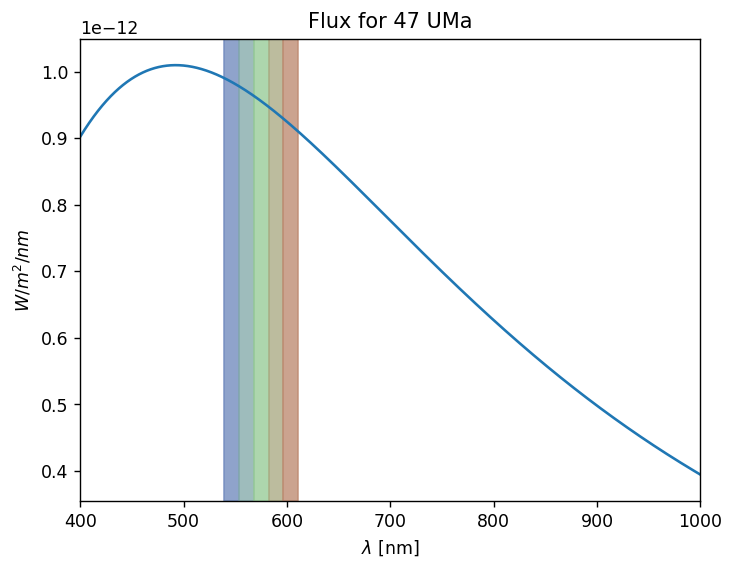

In [6]:
reload(cgi_phasec_poppy.source_flux)

wavelength_c = 575e-9*u.m

nlam = 5
bandwidth = 10/100
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

from astropy.constants import h, c, k_B, R_sun

uma47 = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=5887*u.K,
                                            distance=14.06*u.parsec,
                                            diameter=2*1.172*R_sun,
                                            name='47 UMa')

uma47.plot_spectrum()
# uma47.plot_spectrum_ph()

source_fluxes = uma47.calc_fluxes()
print(source_fluxes)
total_flux = np.sum(source_fluxes)
print(total_flux)

# Test monochromatic PSFs.

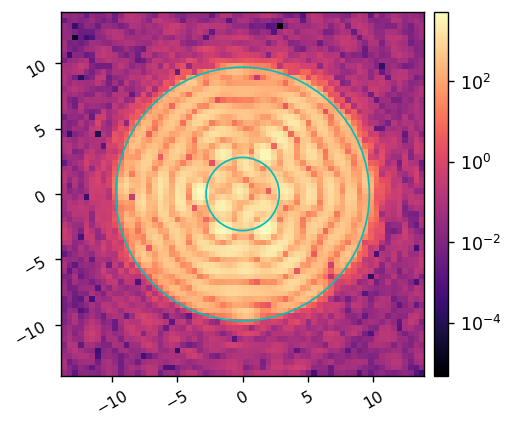

In [9]:
reload(cgi_phasec_poppy.cgi)
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='hlc', 
                               use_pupil_defocus=True, 
                               use_opds=True,
                                dm1_ref=dm1_flat,
                                dm2_ref=dm2_flat,
                                source_flux=total_flux,
                               polaxis=10)

image = mode.snap()

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
imshows.imshow1(image, lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)

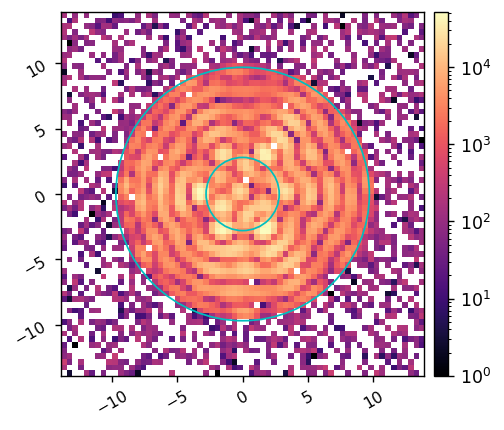

In [10]:
mode.use_noise = True
mode.exp_time = 10*u.s
mode.dark_current_rate = 0.05*u.electron/u.pix/u.hour
# mode.dark_current_rate = 0.0*u.electron/u.pix/u.hour
mode.read_noise = 120*u.electron/u.pix
# mode.read_noise = 0*u.electron/u.pix
mode.gain = 1

noisy_image = mode.snap()

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
imshows.imshow1(noisy_image, lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)

# Test broadband PSF

In [11]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

kwargs = {
    'cgi_mode':'hlc',
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':10,
    'dm1_ref':dm1_flat,
    'dm2_ref':dm2_flat,
}

actors = []
for i in range(nlam):
    actors.append(rayCGI.options(num_gpus=1/nlam).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])
    actors[i].setattr.remote('source_flux', source_fluxes[i])

In [12]:
reload(cgi_phasec_poppy.parallelized_cgi)
hlcbb = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)

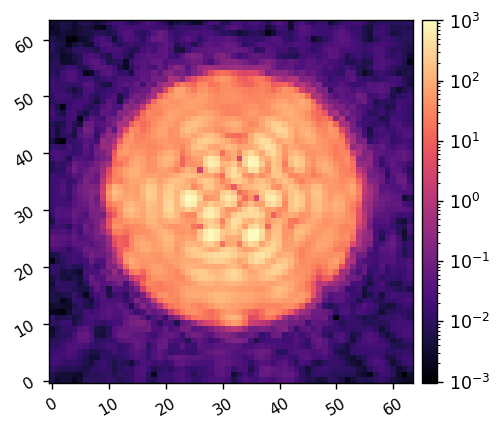

In [13]:
image = hlcbb.snap()
imshows.imshow1(image, lognorm=True)

In [14]:

hlcbb.use_noise = True

hlcbb.exp_time = 5*u.s
hlcbb.dark_current_rate = 0.05*u.electron/u.pix/u.hour
# hlcbb.dark_current_rate = 0.0*u.electron/u.pix/u.hour
hlcbb.read_noise = 120*u.electron/u.pix
# hlcbb.read_noise = 0*u.electron/u.pix
hlcbb.gain = 1

hlcbb.Imax_ref = 1
noisy_image = hlcbb.snap()
imshows.imshow1(noisy_image, lognorm=True)

<class 'cupy.ndarray'> <class 'cupy.ndarray'>


AttributeError: 'ParallelizedCGI' object has no attribute 'Iref'

In [19]:
!nvidia-smi

Mon Jul 24 10:59:12 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           On | 00000000:25:00.0 Off |                    0 |
| N/A   32C    P0               63W / 300W|  13517MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--